In [2]:
import itertools

import numpy
import pandas as pd
import random
import sklearn
from sklearn.model_selection import train_test_split
import datetime
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

import graphviz

In [2]:
"""
Our first goal is going to be data cleaning and munging. We want to take care of all null values
first.
"""

df_training = pd.read_csv('police_killings_train.csv')
df_test = pd.read_csv('police_killings_test.csv')
df_race_city = pd.read_csv('share_race_by_city.csv')
df_income = pd.read_csv('income.csv', encoding="ANSI")
df_poverty = pd.read_csv('poverty.csv', encoding="ANSI")
df_education = pd.read_csv('education.csv', encoding="ANSI")

df_test.info()
df_training

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       507 non-null    int64  
 1   name                     507 non-null    object 
 2   date                     507 non-null    object 
 3   manner_of_death          507 non-null    object 
 4   armed                    504 non-null    object 
 5   age                      467 non-null    float64
 6   gender                   507 non-null    object 
 7   race                     403 non-null    object 
 8   city                     507 non-null    object 
 9   state                    507 non-null    object 
 10  signs_of_mental_illness  507 non-null    bool   
 11  threat_level             507 non-null    object 
 12  flee                     469 non-null    object 
 13  body_camera              507 non-null    bool   
dtypes: bool(2), float64(1), in

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,2256,Jeremy Lopez-Robledo,24/01/17,shot,knife,29.0,M,H,Las Cruces,NM,True,attack,Foot,True
2024,2257,Jonathan David Sper,24/01/17,shot,unarmed,30.0,M,W,Algoma Township,MI,True,attack,Not fleeing,False
2025,2258,Jose Efrain Rodriguez,24/01/17,shot and Tasered,gun,18.0,M,H,Lancaster City,PA,False,attack,Not fleeing,False
2026,2259,Ramon Milanez,24/01/17,shot,gun,32.0,M,H,Kuna,ID,False,attack,Car,False


In [3]:
"""
We will combine the training and tesing dataset to make cleaning easier and more accurate
"""

df_total = df_training.append(df_test, ignore_index=True)
df_total

C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2679408363.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_training.append(df_test, ignore_index=True)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822,Rodney E. Jacobs,28/07/17,shot,gun,31.0,M,NaN,Kansas City,MO,False,attack,Not fleeing,False
2531,2813,TK TK,28/07/17,shot,vehicle,NaN,M,NaN,Albuquerque,NM,False,attack,Car,False
2532,2818,Dennis W. Robinson,29/07/17,shot,gun,48.0,M,NaN,Melba,ID,False,attack,Car,False
2533,2817,Isaiah Tucker,31/07/17,shot,vehicle,28.0,M,B,Oshkosh,WI,False,attack,Car,True


In [4]:
print(df_income.info())
df_race_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29322 entries, 0 to 29321
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic Area  29322 non-null  object
 1   City             29322 non-null  object
 2   Median Income    29271 non-null  object
dtypes: object(3)
memory usage: 687.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29268 entries, 0 to 29267
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Geographic area        29268 non-null  object
 1   City                   29268 non-null  object
 2   share_white            29268 non-null  object
 3   share_black            29268 non-null  object
 4   share_native_american  29268 non-null  object
 5   share_asian            29268 non-null  object
 6   share_hispanic         29268 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB


In [5]:
"""
There are many missing fields across all the supporting/optional datasets, in order to resolve this we need
to merge these datasets and then make the necessary imputation.
1. All data sets have a state and city type columns, merge those columns such that they can all have a column
to for indexing.
2. Get the list of cities within the mandatory dataset, we need to confirm that the supporting dataset
has these cities and if not then we need to impute.
"""
#make a list of unique cities, and include the state so we don't deal with same city names of different states
df_total['city'] = df_total[['state', 'city']].apply("-".join,axis=1)
df_race_city['city'] = df_race_city[['Geographic area', 'City']].apply("-".join,axis=1)
df_income['city'] = df_income[['Geographic Area', 'City']].apply("-".join,axis=1)
df_poverty['city'] = df_poverty[['Geographic Area', 'City']].apply("-".join,axis=1)
df_education['city'] = df_education[['Geographic Area', 'City']].apply("-".join,axis=1)
df_income = df_income.drop(['Geographic Area', 'City'], axis=1)
df_poverty = df_poverty.drop(columns=['Geographic Area', 'City'])
df_education = df_education.drop(columns=['Geographic Area', 'City'])
cities = df_total['city'].tolist()
cities =list(set(cities))
print(len(cities))
cities

1534


['CA-Carson',
 'NM-Santa Fe',
 'NV-Silver Springs',
 'CA-Hawaiian Gardens',
 'GA-Atlanta',
 'IL-Hurst',
 'IL-Arcola',
 'MI-Saginaw',
 'AZ-Cottonwood',
 'LA-Marksville',
 'AR-Farmington',
 'CO-Pueblo',
 'NM-Rowe',
 'OH-Rome',
 'AL-Meridianville',
 'MA-Weymouth',
 'TX-Winnie',
 'GA-Cobb County',
 'CO-Trinidad',
 'IL-Shawnee National Forest',
 'GA-Newnan',
 'IL-Marion',
 'VA-Richmond',
 'CA-Barona Indian Reservation',
 'GA-Cedartown',
 'CA-Moreno Valley',
 'NM-Eldorado',
 'PA-South Greensburg',
 'MS-Ruth',
 'TN-Morristown',
 'MN-Plymouth',
 'CA-West Covina',
 'CT-Fairfield',
 'UT-Milcreek',
 'NC-Raleigh',
 'NC-Pleasant Hill',
 'CA-Lincoln',
 'LA-Gretna',
 'CA-Fontana',
 'CA-La Quinta',
 'KS-Udall',
 'CT-Thomaston',
 'CA-Tustin',
 'UT-Provo',
 'CA-Pleasanton',
 'PA-Somerset',
 'CA-San Mateo',
 'VA-Culpeper',
 'ID-Rexburg',
 'AR-Fayetteville',
 'GA-Albany',
 'FL-Plantation',
 'CA-Pomona',
 'FL-Fort Lauderdale',
 'MN-St. Cloud',
 'SC-Cayce',
 'WA-East Wenatchee',
 'WA-Thurston County',
 'GA-

In [6]:
"""
First lets merge each of the supporting datasets into df_temp.
We noticed that the missing values aren't consistent in the supporting datasets. So we need to change all types of
missing values to NAN such that we can impute using fillna().
"""
print(df_race_city.info())
df_temp = pd.merge(df_race_city, df_income, on='city', how='outer', sort=True)
df_temp = pd.merge(df_temp, df_poverty, on='city', how='outer', sort=True)
df_temp = pd.merge(df_temp, df_education, on='city', how='outer', sort=True)
columns_supp = df_temp.columns.values.tolist()
for i in columns_supp:
    df_temp[i] = df_temp[i].replace('-', '(X)')
    df_temp[i] = df_temp[i].replace('(X)', numpy.NAN)
print(df_temp.info())
df_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29268 entries, 0 to 29267
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Geographic area        29268 non-null  object
 1   City                   29268 non-null  object
 2   share_white            29268 non-null  object
 3   share_black            29268 non-null  object
 4   share_native_american  29268 non-null  object
 5   share_asian            29268 non-null  object
 6   share_hispanic         29268 non-null  object
 7   city                   29268 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29477 entries, 0 to 29476
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Geographic area        29268 non-null  object
 1   City                   29268 non-null  object
 2   share_white        

,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,AK,Adak city,19.6,4,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,AK,Akiak city,5.2,0,92.8,0,0.3,AK-Akiak city,42000,31.3,81.3
4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...
29472,WY,Woods Landing-Jelm CDP,95.9,0,0,2.1,0,WY-Woods Landing-Jelm CDP,NaN,18.6,100
29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523,15.3,85.6
29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114,5.9,89.2
29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0,11.8,WY-Y-O Ranch CDP,NaN,0,100


In [7]:
"""
Let's try cleaning the the race of city dataset now viewing the missing datapoints which are denoted at (X).
"""
# df_temp['city'] = df_temp[['Geographic area', 'City']].apply("-".join,axis=1)
# list_race_df = df_temp.values.tolist()
# j = 0
# list_bad_cities = []
# for i in list_race_df:
#     #we can see it is only null when all races are missing
#     if(i.count('(X)') > 0):
#         j+=1
#         list_bad_cities.append(i[1])
#         print(i.count('(X)') )
# print("total cities with bad points = ", j)


"\nLet's try cleaning the the race of city dataset now viewing the missing datapoints which are denoted at (X).\n"

In [8]:
"""With only 20/29260 holding a row of null values, we shall drop these cities"""
# tempDf_race = df_temp[df_race_city.share_white != '(X)'].copy()
# print(tempDf_race.info())
# df_race_city.info()

'With only 20/29260 holding a row of null values, we shall drop these cities'

In [9]:
"""
We want to make sure all the cities that are in our mandatory dataset is accounted for in the supporting.
We shall add those cities if they aren't and impute them as nulls
"""
#we can check that all the cities in the total data set is still in the race_city dataset
cities2 = df_temp['city'].tolist()
cities2 =list(set(cities2))
j = 0
missing = 0
cities.sort()
cities2.sort()
rep_val = 0
for i in cities:
    # print(i in cities2)
    # print(i)
    # print(cities2.index(i[0::1]))
    if(i in cities2):
        j+=1
    elif(any(i in string for string in cities2)):
        if len(df_temp[df_temp['city'].str.contains(i) ]) == 1 and sum(i in string for string in cities) == 1:
            print(i)
            df_temp['city'].loc[df_temp['city'].str.contains(i)] = i
            rep_val+=1

        else:
            newDF = {}
            #print(i)
            newDF['Geographic area'] = i[0:2]
            newDF['City'] = i[3:]
            newDF['city'] = i
            ind = 0
            df_temp = df_temp.append(newDF, ignore_index=True)
            cities2 = df_temp['city'].tolist()
            cities2 =list(set(cities2))
            missing+=1

    else:
        newDF = {}
        #print(i)
        newDF['Geographic area'] = i[0:2]
        newDF['City'] = i[3:]
        newDF['city'] = i
        ind = 0
        df_temp = df_temp.append(newDF, ignore_index=True)
        cities2 = df_temp['city'].tolist()
        cities2 =list(set(cities2))
        missing+=1


print(j)
print("Replaced cities ", rep_val)
print(" Was Missing ", missing)
df_temp.drop_duplicates(subset='city', inplace=True)
df_temp.reset_index(inplace=True)
df_temp

AK-Anchorage
AK-Barrow
AK-Big Lake
AK-Fairbanks
AK-Houston
AK-Wasilla
AL-Abbeville
AL-Arab
AL-Ashville
AL-Bay Minette


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

AL-Birmingham
AL-Clanton
AL-Dadeville
AL-Deer Park
AL-Eufaula
AL-Gadsden
AL-Homewood
AL-Hoover
AL-Huntsville


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

AL-Meridianville
AL-Millbrook
AL-Mobile
AL-Monroeville
AL-Montgomery
AL-Muscle Shoals
AL-Opelika
AL-Opp
AL-Oxford
AL-Phenix City
AL-Piedmont
AL-Rainbow City
AL-Saraland
AL-Selma
AL-Sylacauga
AL-Tuscaloosa
AL-Tuscumbia
AL-Westover
AR-Austin
AR-Bull Shoals
AR-Cabot
AR-Dover
AR-England


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


AR-Farmington
AR-Fayetteville
AR-Jonesboro
AR-Little Rock
AR-Manila
AR-Marion
AR-Mena
AR-Mountain Pine
AR-Perryville
AR-Sheridan
AR-Springdale
AR-Strong
AR-West Memphis


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


AZ-Apache Junction
AZ-Avondale
AZ-Bisbee
AZ-Buckeye
AZ-Bullhead City
AZ-Casa Grande
AZ-Chandler
AZ-Eagar
AZ-Flagstaff
AZ-Florence
AZ-Gilbert
AZ-Glendale
AZ-Golden Shores
AZ-Golden Valley
AZ-Kearny
AZ-Kingman
AZ-Lake Havasu City
AZ-Marana
AZ-Morenci
AZ-Phoenix


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

AZ-San Manuel
AZ-Scottsdale
AZ-Show Low
AZ-Somerton
AZ-Surprise
AZ-Tempe
AZ-Wilhoit


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


AZ-Yuma
CA-Aguanga
CA-Anaheim
CA-Anderson
CA-Antelope
CA-Antioch
CA-Apple Valley
CA-Atascadero
CA-Atwater
CA-Avenal
CA-Azusa
CA-Bakersfield
CA-Barstow
CA-Beaumont
CA-Bellflower
CA-Boulder Creek
CA-Brawley
CA-Byron
CA-Cabazon


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Calexico
CA-Calimesa
CA-Camarillo
CA-Campo
CA-Carmichael
CA-Carson
CA-Castaic
CA-Cathedral City
CA-Ceres
CA-Cerritos
CA-Chico
CA-Chowchilla


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Chula Vista
CA-Citrus Heights
CA-Clovis
CA-Coalinga
CA-Colton
CA-Compton
CA-Concord
CA-Corning
CA-Cottonwood
CA-Del Mar
CA-Delano
CA-Delhi
CA-Desert Edge
CA-Dinuba
CA-Douglas City
CA-Downey
CA-Dunsmuir
CA-El Cajon
CA-El Monte
CA-Elk Grove
CA-Emeryville
CA-Encinitas
CA-Escondido
CA-Eureka


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


CA-Fair Oaks
CA-Fairfield
CA-Florence
CA-Fontana
CA-Fountain Valley
CA-Fremont
CA-Fresno
CA-Fullerton
CA-Gardena
CA-Gilroy
CA-Glendale
CA-Grass Valley
CA-Grover Beach
CA-Hacienda Heights
CA-Hawaiian Gardens
CA-Hawthorne
CA-Hayward
CA-Hemet
CA-Hesperia
CA-Highgrove
CA-Huntington Beach
CA-Huntington Park


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Inglewood
CA-Inyokern
CA-Irvine
CA-Jurupa Valley
CA-La Mirada
CA-La Quinta
CA-Ladera Heights
CA-Lake Elsinore
CA-Lakewood
CA-Lancaster


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Lodi
CA-Lompoc
CA-Long Beach
CA-Los Angeles
CA-Lynwood
CA-Maywood
CA-Meadow Vista
CA-Merced
CA-Modesto
CA-Montclair
CA-Montebello
CA-Moreno Valley
CA-Napa
CA-Needles
CA-Newark
CA-Newman
CA-Newport Beach
CA-Norwalk
CA-Oakland
CA-Olivehurst


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Ontario
CA-Oxnard
CA-Palm Springs
CA-Palmdale
CA-Palo Alto
CA-Pico Rivera
CA-Pleasanton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Pomona
CA-Porterville
CA-Poway
CA-Rancho Cordova
CA-Rancho Santa Margarita
CA-Redding
CA-Redlands
CA-Rialto
CA-Ripon
CA-Riverside
CA-Rocklin
CA-Rosemead
CA-Sacramento
CA-Salinas
CA-San Bernardino
CA-San Fernando
CA-San Francisco
CA-San Jose
CA-San Marcos
CA-San Mateo
CA-Sand City
CA-Santa Ana
CA-Santa Barbara
CA-Santa Clara


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


CA-Santa Clarita
CA-Santa Cruz
CA-Santa Maria
CA-Santa Monica
CA-Santa Nella
CA-Santa Paula
CA-Santee
CA-Saratoga
CA-Seaside
CA-Selma
CA-Shafter
CA-Smartsville


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Solvang
CA-South El Monte
CA-South Gate
CA-South Lake Tahoe
CA-Stockton
CA-Sunnyvale
CA-Tehachapi
CA-Temecula
CA-Torrance
CA-Turlock
CA-Tustin
CA-Twentynine Palms
CA-Union City
CA-Vacaville
CA-Valinda
CA-Vallejo
CA-Visalia
CA-Walnut Creek
CA-Wasco


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CA-Watsonville
CA-West Covina
CA-West Goshen
CA-Whittier
CA-Winchester
CA-Windsor
CA-Yorba Linda
CA-Yreka
CA-Yuba City
CO-Aurora


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


CO-Boulder
CO-Brighton
CO-Broomfield
CO-Centennial
CO-Colorado City
CO-Colorado Springs
CO-Commerce City
CO-Denver
CO-Dinosaur
CO-Eldorado Springs
CO-Englewood
CO-Evans
CO-Federal Heights
CO-Fort Collins
CO-Fountain
CO-Grand Junction
CO-Greeley
CO-Lakewood
CO-Loveland
CO-Mountain View
CO-New Castle
CO-Northglenn
CO-Parker


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

CO-Strasburg
CO-Thornton
CO-Trinidad
CO-Westminster
CT-Bridgeport
CT-Mashantucket
CT-Old Saybrook
CT-Stamford
CT-Suffield
CT-Thomaston


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


DC-Washington
DE-Claymont
DE-Frederica
DE-Middletown
DE-New Castle
DE-Smyrna
FL-Auburndale
FL-Belle Glade
FL-Brooksville


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

FL-Callahan
FL-Cape Canaveral
FL-Cape Coral
FL-Clermont
FL-Crescent City
FL-Crystal Springs


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


FL-Delray Beach
FL-Deltona
FL-Englewood
FL-Floral City
FL-Fort Lauderdale
FL-Fort Walton Beach
FL-Fruitland Park
FL-Gainesville
FL-Gifford
FL-Hallandale Beach


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

FL-Holiday
FL-Immokalee
FL-Lake Wales
FL-Largo
FL-Lealman


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

FL-Loxahatchee
FL-Manatee
FL-Mascotte
FL-Miami Beach
FL-Miami Gardens
FL-Micanopy
FL-Middleburg
FL-Milton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

FL-Niceville
FL-Noma
FL-North Port
FL-Oakland Park
FL-Ocala
FL-Orange City
FL-Orange Park
FL-Orlando
FL-Palm Bay
FL-Palm Beach Gardens


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


FL-Palm Harbor
FL-Panama City Beach
FL-Pensacola
FL-Pinellas Park
FL-Plant City
FL-Pompano Beach
FL-Port St. Lucie
FL-Riverview
FL-Sneads


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

FL-St. Petersburg
FL-Tallahassee
FL-Tampa
FL-Thonotosassa
FL-Titusville
FL-Wellington
FL-West Palm Beach
FL-Yulee
GA-Acworth
GA-Albany
GA-Arlington
GA-Atlanta
GA-Austell
GA-Brooklet
GA-Carrollton
GA-Cartersville
GA-Cedartown
GA-Clarkesville
GA-Cochran
GA-Commerce


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

GA-Covington
GA-Cumming
GA-Decatur
GA-Douglasville
GA-East Point
GA-Elberton
GA-Fort Valley
GA-Gainesville
GA-Hampton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

GA-Jesup
GA-Lawrenceville
GA-Loganville
GA-Ludowici
GA-Lumpkin
GA-Mableton
GA-Marietta
GA-Moultrie
GA-Newnan
GA-Peachtree City


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


GA-Port Wentworth
GA-Powder Springs
GA-Riverdale
GA-Rossville
GA-Savannah
GA-Smyrna
GA-Stockbridge
GA-Stone Mountain
GA-Sylvester
GA-Talking Rock
GA-Tyrone
GA-Valdosta


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

GA-Woodstock
HI-Aiea
HI-Hilo
HI-Kahuku
HI-Keaau
IA-Boone
IA-Burlington
IA-Cedar Rapids
IA-Des Moines
IA-Fort Madison
IA-North English
IA-Sioux City
IA-Urbandale
IA-Wellman
ID-Boise
ID-Council
ID-Garden City
ID-Homedale
ID-Idaho Falls
ID-Kuna
ID-Melba
ID-Middleton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

ID-Rexburg
ID-Sandpoint
IL-Antioch
IL-Arcola
IL-Belleville
IL-Benton
IL-Clinton
IL-Deerfield
IL-Dolton
IL-East St. Louis


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


IL-Forest Park
IL-Harvey
IL-Hurst
IL-Jerseyville
IL-Lansing
IL-Lisle
IL-Lyons
IL-Maeystown
IL-Marion
IL-Markham
IL-Metropolis
IL-North Riverside
IL-Rantoul
IL-River Forest
IL-Rockford
IL-Springfield
IL-Stockton
IL-Villa Park
IL-Washington Park
IL-Zion


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


IN-Avon
IN-Beech Grove
IN-Brookville
IN-Elkhart
IN-English
IN-Evansville
IN-Fishers
IN-Fort Wayne
IN-French Lick
IN-Gary
IN-Goshen
IN-Greenwood
IN-Hanover
IN-Harmony
IN-Knox
IN-Kokomo
IN-Lafayette
IN-Monon
IN-Muncie
IN-Portage
IN-Shelbyville
IN-Terre Haute
IN-Vincennes
KS-Assaria


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


KS-Colby
KS-Gardner
KS-Hesston
KS-Hutchinson
KS-Kansas City
KS-Leavenworth
KS-Lehigh
KS-McPherson
KS-Medicine Lodge
KS-Newton
KS-Olathe
KS-Rosalia


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


KS-Topeka
KS-Udall
KS-Wichita
KY-Barbourville
KY-Bardstown
KY-Berea
KY-Booneville
KY-Bowling Green
KY-Brodhead
KY-Burkesville
KY-Edmonton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

KY-Elizabethtown
KY-Elsmere
KY-Fulton
KY-Georgetown
KY-Hiseville
KY-Lancaster
KY-Lawrenceburg
KY-Leitchfield
KY-London


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

KY-Ludlow
KY-Morehead
KY-Owensboro
KY-Paris
KY-Phelps
KY-Princeton
KY-Richmond
KY-Russellville
KY-White Plains
KY-Wilmore
LA-Alexandria
LA-Baton Rouge
LA-Bossier City
LA-Breaux Bridge
LA-Cade
LA-Chalmette
LA-Converse
LA-Covington
LA-Crowley
LA-Denham Springs
LA-Gretna


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

LA-Harvey
LA-Homer
LA-Houma
LA-Kenner
LA-Mamou
LA-Mandeville
LA-Marksville
LA-Metairie
LA-New Iberia
LA-New Orleans


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


LA-Pineville
LA-Plaquemine
LA-Port Barre
LA-Raceland
LA-Shreveport
LA-Slidell
LA-Winnsboro
MA-Beverly
MA-Boston
MA-Braintree
MA-Brockton
MA-Everett
MA-Lowell
MA-Oxford
MA-Spencer
MA-Taunton
MA-Webster
MA-West Springfield
MA-Weymouth


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

MD-Capitol Heights
MD-Chestertown
MD-Columbia
MD-District Heights
MD-Dundalk
MD-Elkridge
MD-Elkton
MD-Essex
MD-Fort Meade
MD-Frederick
MD-Greenbelt
MD-Middle River


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


MD-Montgomery Village
MD-North East
MD-Overlea
MD-Owings Mills
MD-Pikesville
MD-Randallstown
MD-Reisterstown
MD-Rising Sun
MD-Salisbury
ME-Bangor


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

ME-Madison
ME-Naples
ME-Portland
ME-Presque Isle
ME-Waldoboro
MI-Bay City
MI-Beaverton
MI-Belleville
MI-Benton Harbor


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

MI-Grand Rapids
MI-Kentwood
MI-Lansing
MI-Marion
MI-Portage
MI-Romulus
MI-Saginaw
MI-Southfield


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


MI-St. Joseph
MI-Trenton
MI-Warren
MI-Wyoming
MN-Aitkin
MN-Alexandria
MN-Austin
MN-Bloomington
MN-Burnsville
MN-Cohasset
MN-Columbia Heights
MN-Eagan
MN-Falcon Heights
MN-Fridley
MN-Hutchinson
MN-Mankato
MN-Minneapolis
MN-Mora
MN-New Hope
MN-North Branch
MN-Peterson
MN-Plymouth
MN-Roseville
MN-St. Cloud
MN-Vadnais Heights


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


MN-Vineland
MO-Affton
MO-Blue Springs
MO-Buffalo
MO-Cape Girardeau
MO-Columbia
MO-Florissant
MO-Harrisonville
MO-Independence
MO-Jennings


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

MO-Kansas City
MO-Lakeshire
MO-Lee's Summit
MO-Maysville
MO-Neosho
MO-Nevada
MO-Odessa
MO-Ozark
MO-Poplar Bluff
MO-Republic


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


MO-Sedalia
MO-Springfield
MO-St. Joseph
MO-St. Louis
MO-Sugar Creek
MO-Sullivan
MS-Biloxi
MS-Brookhaven
MS-Gautier
MS-Greenville


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


MS-Gulfport
MS-Hattiesburg
MS-Iuka
MS-Lucedale
MS-Petal
MS-Smithville
MS-Southaven
MS-St. Martin
MS-Tupelo
MS-Walls
MS-Water Valley
MT-Billings


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


MT-Dillon
MT-Huntley
MT-Livingston
MT-Malta
MT-Superior
MT-Three Forks
NC-Archdale
NC-Asheville
NC-Brevard
NC-Canton
NC-Cary
NC-Charlotte
NC-Clinton
NC-Dallas
NC-Dublin
NC-Durham
NC-East Flat Rock
NC-Efland
NC-Fayetteville
NC-Gastonia
NC-Granite Falls


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


NC-Greensboro
NC-Greenville
NC-Hickory
NC-Hudson
NC-Kinston
NC-Lawndale
NC-Leland
NC-Lenoir
NC-Lumberton
NC-Maiden
NC-Newton Grove
NC-Peachland
NC-Pinnacle
NC-Pleasant Hill
NC-Raleigh
NC-Ronda
NC-Rowland
NC-Rutherfordton
NC-Salemburg
NC-Salisbury
NC-Shelby
NC-Spring Lake
NC-Statesville
NC-Stoneville
NC-Tarboro
NC-Wadesboro
NC-Wake Forest
NC-Wilkesboro
ND-Bismarck
ND-Mandan
NE-Big Springs
NE-Lincoln
NE-Louisville
NE-Omaha


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


NE-Sidney
NE-York
NH-Claremont
NH-Derry
NH-Peterborough
NJ-Atlantic City
NJ-Bridgeton
NJ-Byram


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

NJ-Camden
NJ-Hackensack
NJ-Hamilton
NJ-New Brunswick
NJ-Newark
NJ-Old Bridge
NJ-Paterson


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

NJ-Toms River
NJ-Trenton
NJ-Ventnor
NJ-Vineland
NJ-Woodbridge
NM-Alamogordo
NM-Albuquerque
NM-Artesia
NM-Carlsbad
NM-Carrizozo
NM-Crownpoint
NM-Deming
NM-Edgewood
NM-Eldorado
NM-Gallup
NM-Hanover
NM-Hobbs
NM-Jal
NM-Las Cruces
NM-Los Lunas
NM-Lovington
NM-Roswell
NM-Rowe


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

NM-San Rafael
NM-Santa Fe
NM-Socorro
NM-Truth or Consequences
NV-Boulder City
NV-Gardnerville Ranchos
NV-Henderson
NV-Las Vegas
NV-North Las Vegas
NV-Pahrump


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


NV-Reno
NV-Silver Springs
NV-Sparks
NY-Beacon
NY-Bronx
NY-Buffalo
NY-Cheektowaga
NY-Constantia


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

NY-Greece
NY-Malone
NY-Middletown
NY-Mount Vernon
NY-New City
NY-New Paltz
NY-Potsdam
NY-Rochester
NY-Rotterdam


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


NY-Schenectady
NY-Syracuse
NY-Troy
NY-Yonkers
OH-Akron
OH-Ashtabula
OH-Beverly
OH-Brookville
OH-Canton
OH-Celina
OH-Cincinnati
OH-Circleville


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

OH-Dayton
OH-Englewood
OH-Euclid
OH-Fairborn
OH-Findlay
OH-Hamilton
OH-Hudson


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

OH-Mansfield
OH-Medina
OH-Montpelier
OH-North Royalton
OH-Northwood
OH-Oak Hill
OH-Richmond Heights
OH-Rome
OH-Springfield


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

OH-Tiffin
OH-Toledo
OH-Uniontown
OH-Vandalia
OH-Westerville
OH-Westlake
OH-Zanesville
OK-Anadarko
OK-Ardmore
OK-Bartlesville
OK-Bethany
OK-Broken Bow
OK-Burns Flat
OK-Byars
OK-Byng
OK-Cache
OK-Chickasha
OK-Colbert
OK-Cushing
OK-Edmond
OK-Eufaula


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


OK-Fairfax
OK-Fairland
OK-Guthrie
OK-Healdton
OK-Hominy
OK-Kellyville
OK-Kiowa
OK-Lawton
OK-Leedey
OK-McAlester
OK-Miami
OK-Midwest City


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

OK-Millerton
OK-Muskogee
OK-Okemah
OK-Oklahoma City
OK-Ponca City
OK-Pryor
OK-Roland
OK-Rush Springs
OK-Sallisaw


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


OK-Sand Springs
OK-Schulter
OK-Stillwater
OK-Tahlequah
OK-Tulsa
OK-Wagoner
OK-Watts
OK-Wetumka
OK-Wewoka
OR-Aloha
OR-Beaverton
OR-Bend
OR-Burns
OR-Dallas
OR-Eugene
OR-Florence
OR-Grants Pass
OR-Gresham
OR-King City
OR-McMinnville
OR-Medford
OR-Oregon City
OR-Portland


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


OR-Salem
OR-Seaside
OR-Springfield
OR-Tualatin
OR-West Linn
PA-Allentown
PA-Avella
PA-Bloomsburg
PA-Campbelltown
PA-Chambersburg


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

PA-East Stroudsburg
PA-Harrisburg
PA-Hummelstown
PA-Johnstown
PA-Knoxville
PA-Lewistown


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

PA-Philadelphia
PA-Pittsburgh
PA-Pittston
PA-Reading
PA-Somerset
PA-South Greensburg
PA-Stewartstown
PA-West Chester
PA-Wilkinsburg


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

RI-Pawtucket
RI-Tiverton
SC-Aiken
SC-Boiling Springs
SC-Campobello
SC-Cayce
SC-Charleston
SC-Fountain Inn
SC-Goose Creek
SC-Greenville
SC-Hardeeville


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


SC-Irmo
SC-Iva
SC-Johnsonville
SC-Lake City
SC-Lake View
SC-Lancaster
SC-Landrum
SC-Latta
SC-Lexington
SC-Little Mountain
SC-Moncks Corner
SC-Myrtle Beach
SC-North Charleston
SC-Pelzer
SC-Pendleton
SC-Piedmont
SC-Seneca
SC-Spartanburg
SC-Summerville
SC-Sumter
SC-Taylors
SD-Kyle
SD-Lead
SD-Mitchell
SD-Rapid City
SD-Rapid Valley
SD-Rosebud
SD-Sioux Falls
TN-Alamo
TN-Arlington
TN-Bristol
TN-Chattanooga
TN-Clarksville
TN-Columbia
TN-Dickson
TN-East Ridge
TN-Elizabethton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


TN-Estill Springs
TN-Franklin
TN-Gallatin
TN-Hendersonville
TN-Hohenwald
TN-Humboldt
TN-Jackson
TN-Johnson City
TN-Knoxville
TN-Lakeland


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


TN-Lenoir City
TN-Lewisburg
TN-McLemoresville
TN-Memphis
TN-Monteagle
TN-Morristown
TN-Oneida
TN-Sevierville
TN-Shelbyville


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

TN-Soddy-Daisy
TN-Somerville
TN-Sparta
TN-Spring Hill
TX-Abilene
TX-Addison
TX-Allen
TX-Amarillo
TX-Arlington
TX-Austin
TX-Azle
TX-Balch Springs
TX-Baytown
TX-Beaumont
TX-Beckville
TX-Bellville
TX-Boerne
TX-Brookshire
TX-Brownsville
TX-Carrollton
TX-Chapeno
TX-Cisco


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


TX-Clute
TX-Conroe
TX-Corpus Christi
TX-Dallas
TX-DeSoto
TX-Del Rio
TX-Denton
TX-Edinburg
TX-El Paso
TX-Euless
TX-Fort Stockton
TX-Fort Worth
TX-Freeport


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


TX-Friendswood
TX-Fritch
TX-Fulshear
TX-Garland
TX-Gilmer
TX-Gladewater
TX-Groveton
TX-Harker Heights
TX-Houston
TX-Hurst


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


TX-Hutchins
TX-Irving
TX-Jourdanton
TX-Katy
TX-Kerrville
TX-Killeen
TX-Kingsbury
TX-Lake Jackson
TX-Levelland
TX-Lockhart


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

TX-Longview
TX-Lorena
TX-Lufkin
TX-Mabank
TX-Mansfield
TX-Midland
TX-Midlothian
TX-Nacogdoches


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

TX-Odessa
TX-Onalaska
TX-Palestine
TX-Panhandle
TX-Paris
TX-Pearland
TX-Pharr
TX-Plano
TX-Ponder
TX-Port Arthur
TX-Rosenberg


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


TX-Rosser
TX-Saginaw
TX-San Angelo
TX-San Antonio
TX-Seagoville
TX-Sierra Blanca
TX-Splendora
TX-Springtown
TX-Tahoka
TX-Temple


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

TX-Tomball
TX-Waco
TX-Weatherford
TX-Webster
TX-West Odessa
TX-Whitewright
TX-Wichita Falls
TX-Wink
TX-Winnie
UT-Centerville
UT-Clearfield
UT-Draper
UT-Eagle Mountain
UT-Ogden
UT-Parowan
UT-Provo
UT-Roosevelt
UT-Roy
UT-Salt Lake City
UT-Spanish Fork


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

UT-Syracuse
UT-West Jordan
VA-Alexandria
VA-Arlington
VA-Chesapeake
VA-Concord
VA-Culpeper
VA-Emporia
VA-Falls Church
VA-Fredericksburg


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


VA-Grundy
VA-Harrisonburg
VA-Herndon
VA-Hopewell
VA-King George
VA-Newport News
VA-Norfolk
VA-Pearisburg
VA-Portsmouth
VA-Pulaski
VA-Richmond


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

VA-Roanoke
VA-Stafford
VA-Suffolk
VA-Virginia Beach
VA-Winchester
VT-Burlington
VT-Winooski
WA-Auburn
WA-Bainbridge Island
WA-Bellingham


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


WA-Burien
WA-Cle Elum
WA-Des Moines
WA-East Wenatchee
WA-Everett
WA-Federal Way
WA-Graham
WA-Grapeview
WA-Kelso
WA-Kennewick
WA-Kent
WA-Kirkland
WA-Lacey
WA-Lake Stevens
WA-Lakewood
WA-Lynnwood
WA-Olympia
WA-Pasco
WA-Richland
WA-Ridgefield
WA-Seattle
WA-Shelton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


WA-Snohomish
WA-Spanaway
WA-Sumas
WA-Tacoma
WA-Tukwila
WA-Vancouver
WA-Wapato
WA-Wenatchee
WA-Woodland
WA-Yakima
WI-Antigo


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


WI-Appleton
WI-Ashwaubenon
WI-Beaver Dam
WI-East Troy
WI-Eau Claire
WI-Fond du Lac
WI-Green Bay
WI-Greenfield
WI-Jackson
WI-Kenosha
WI-Lake Hallie


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


WI-Madison
WI-Millston
WI-Milwaukee
WI-Monroe
WI-Neenah
WI-New London
WI-Oshkosh
WI-Paddock Lake
WI-Pembine
WI-Pine River
WI-Rib Mountain


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ign

WI-Waukesha
WI-Wauwatosa
WI-West Allis
WI-Weston
WV-Beckley
WV-Bluefield
WV-Brandywine
WV-Buckhannon
WV-Clendenin
WV-Elkins
WV-Fairmont
WV-Follansbee
WV-Fort Ashby
WV-Grafton
WV-Hometown
WV-Meadow Bridge
WV-Montcalm
WV-Morgantown
WV-Mount Hope
WV-Nitro
WV-Princeton


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


WV-Spencer
WV-Weirton
WY-Cheyenne
WY-Douglas
WY-Gillette
WY-Laramie
WY-Rawlins
1
Replaced cities  1189
 Was Missing  344


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\2341017669.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(newDF, ignore_index=True)


,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,3,AK,Akiak city,5.2,0,92.8,0,0.3,AK-Akiak city,42000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...,...
29816,29816,WV,Braxton County,NaN,NaN,NaN,NaN,NaN,WV-Braxton County,NaN,NaN,NaN
29817,29817,WV,Gerrardstown,NaN,NaN,NaN,NaN,NaN,WV-Gerrardstown,NaN,NaN,NaN
29818,29818,WV,Hensley,NaN,NaN,NaN,NaN,NaN,WV-Hensley,NaN,NaN,NaN
29819,29819,WV,Petroleum,NaN,NaN,NaN,NaN,NaN,WV-Petroleum,NaN,NaN,NaN


In [10]:
cities2 = df_temp['city'].tolist()
cities2 =list(set(cities2))
j = 0
for i in cities:
    # print(i in cities2)
    # print(i)
    # print(cities2.index(i[0::1]))
    if(i in  cities2):
        j+=1
#confirming that all the cities were placed in
print(j)

1534


In [11]:
df_temp.sort_values(by=['city'], inplace=True)
df_temp

,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,3,AK,Akiak city,5.2,0,92.8,0,0.3,AK-Akiak city,42000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...,...
29472,29472,WY,Woods Landing-Jelm CDP,95.9,0,0,2.1,0,WY-Woods Landing-Jelm CDP,NaN,18.6,100
29473,29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523,15.3,85.6
29474,29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114,5.9,89.2
29475,29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0,11.8,WY-Y-O Ranch CDP,NaN,0,100


In [12]:
"""
We want to impute the city and our state/Geographic area such that we have a full comprehensive list of both
separately after the merge.
Then we want to get a list of race names within the df_race_city.
"""

df_temp['Geographic area'] = [i[0:2] for i in df_temp['city']]
df_temp['City'] = [i[3:] for i in df_temp['city']]
print(df_temp)
list_states = df_temp['Geographic area'].values.tolist()
list_states = list(set(list_states))
#we expect to see 51 including DC as a state
print(len(list_states))
columns_race = df_temp.columns.values.tolist()
s = 'share'
columns_race = [string for string in columns_race if(s in string)]
columns_race

       index Geographic area                    City share_white share_black  \
0          0              AK               Adak city        19.6           4   
1          1              AK             Akhiok city         8.5         1.4   
2          2              AK            Akiachak CDP         3.5         0.2   
3          3              AK              Akiak city         5.2           0   
4          4              AK             Akutan city        23.3        17.9   
...      ...             ...                     ...         ...         ...   
29472  29472              WY  Woods Landing-Jelm CDP        95.9           0   
29473  29473              WY            Worland city        89.9         0.3   
29474  29474              WY             Wright town        94.5         0.1   
29475  29475              WY           Y-O Ranch CDP        92.8         1.5   
29476  29476              WY              Yoder town        97.4           0   

      share_native_american share_asian

['share_white',
 'share_black',
 'share_native_american',
 'share_asian',
 'share_hispanic']

In [13]:
"""
Now we can impute the porportion of missing cities based on the state's porportions
"""
for state in list_states:
    j=0
    list_total_races = []
    state_df = df_temp.loc[df_temp['Geographic area'] == state]
    for i in columns_race:
        state_df[i] = state_df[i].astype(float)
        list_total_races.append(state_df[i].sum())
        print(list_total_races[j])
        j+=1
    sum_all_races = sum(list_total_races)
    porportional_share = [i/sum_all_races for i in list_total_races]
    #print(porportional_share, " sum= ", sum(porportional_share))
    j=0
    for i in columns_race:
        state_df[i] = state_df[i].fillna(porportional_share[j])
        j+=1
    df_temp.loc[df_temp['Geographic area'] == state] = state_df
print(df_temp.info())
df_temp



144370.7
10277.8
1151.6999999999998
1773.8000000000002
68809.79999999999
18659.5
80.69999999999999
625.2
78.7
1215.6
5038.799999999999
161.7
58.60000000000001
3873.9


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1632609194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df[i] = state_df[i].astype(float)
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1632609194.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df[i] = state_df[i].fillna(porportional_share[j])


1564.1
20161.6
67.0
573.1
110.69999999999999
2427.8
30833.699999999997
82.7
4332.900000000001
116.4
800.1
37009.799999999996
143.3
2137.3
117.69999999999999
731.0
164498.7
5768.7
285.0
1744.6
4820.2
12534.900000000001
107.39999999999999
71.4
135.2
172.0
38158.3
3132.9
135.8
273.4
1225.3
33078.9
113.1
4690.400000000001
124.0
794.4000000000001
38109.200000000004
1169.0
80.30000000000001
136.8
362.59999999999997
24480.399999999998
12969.599999999999
182.8
292.3
1767.8
44086.9
9757.9
202.3
2168.3999999999996
3636.4
16068.800000000001
199.70000000000002
16144.4
488.7
756.5
83171.0
906.7
3047.0
929.3
2857.4
72378.70000000001
12301.199999999999
419.0
1487.4
15206.8
12313.100000000002
713.8999999999999
93.9
427.5
1140.5
30657.300000000003
14556.8
452.8
372.0
1407.9
41909.200000000004
13480.3
381.09999999999997
277.29999999999995
1722.5
54936.2
243.89999999999998
904.7
169.3
2360.7
40197.899999999994
420.30000000000007
744.2
528.9000000000001
8197.6
21790.300000000003
680.9
64.7
693.4
1201.9
71

,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4.0,5.5,52.5,8.9,AK-Adak city,78500,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750,26.1,76.7
3,3,AK,Akiak city,5.2,0.0,92.8,0.0,0.3,AK-Akiak city,42000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750,16.1,73
...,...,...,...,...,...,...,...,...,...,...,...,...
29472,29472,WY,Woods Landing-Jelm CDP,95.9,0.0,0.0,2.1,0.0,WY-Woods Landing-Jelm CDP,NaN,18.6,100
29473,29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523,15.3,85.6
29474,29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114,5.9,89.2
29475,29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0.0,11.8,WY-Y-O Ranch CDP,NaN,0,100


In [14]:
df_temp['Median Income'] = pd.to_numeric(df_temp['Median Income'], errors='coerce')
df_temp['poverty_rate'] = pd.to_numeric(df_temp['poverty_rate'], errors='coerce')
df_temp['percent_completed_hs'] = pd.to_numeric(df_temp['percent_completed_hs'], errors='coerce')
for state in list_states:
    state_df = df_temp.loc[df_temp['Geographic area'] == state]
    state_df['Median Income'] = state_df['Median Income'].fillna(state_df['Median Income'].mean())
    state_df['poverty_rate'] = state_df['poverty_rate'].fillna(state_df['poverty_rate'].mean())
    state_df['percent_completed_hs'] =state_df['percent_completed_hs'].fillna(state_df['percent_completed_hs'].mean())
    df_temp.loc[df_temp['Geographic area'] == state] = state_df
print(df_temp.info())

df_temp

C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\3410407094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['Median Income'] = state_df['Median Income'].fillna(state_df['Median Income'].mean())
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\3410407094.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['poverty_rate'] = state_df['poverty_rate'].fillna(state_df['poverty_rate'].mean())
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\3410407094.py:8: SettingWithCopyWarning: 
A value

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29821 entries, 0 to 29476
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  29821 non-null  int64  
 1   Geographic area        29821 non-null  object 
 2   City                   29821 non-null  object 
 3   share_white            29821 non-null  object 
 4   share_black            29821 non-null  object 
 5   share_native_american  29821 non-null  object 
 6   share_asian            29821 non-null  object 
 7   share_hispanic         29821 non-null  object 
 8   city                   29821 non-null  object 
 9   Median Income          29821 non-null  float64
 10  poverty_rate           29821 non-null  float64
 11  percent_completed_hs   29821 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 3.0+ MB
None


,index,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs
0,0,AK,Adak city,19.6,4.0,5.5,52.5,8.9,AK-Adak city,78500.000000,39.3,93.4
1,1,AK,Akhiok city,8.5,1.4,50.7,1.4,11.3,AK-Akhiok city,26250.000000,40.5,62.5
2,2,AK,Akiachak CDP,3.5,0.2,95.1,0.2,0.2,AK-Akiachak CDP,38750.000000,26.1,76.7
3,3,AK,Akiak city,5.2,0.0,92.8,0.0,0.3,AK-Akiak city,42000.000000,31.3,81.3
4,4,AK,Akutan city,23.3,17.9,5.5,43.3,20.8,AK-Akutan city,24750.000000,16.1,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29472,29472,WY,Woods Landing-Jelm CDP,95.9,0.0,0.0,2.1,0.0,WY-Woods Landing-Jelm CDP,60874.993464,18.6,100.0
29473,29473,WY,Worland city,89.9,0.3,1.3,0.6,16.6,WY-Worland city,41523.000000,15.3,85.6
29474,29474,WY,Wright town,94.5,0.1,1.4,0.2,6.2,WY-Wright town,77114.000000,5.9,89.2
29475,29475,WY,Y-O Ranch CDP,92.8,1.5,2.6,0.0,11.8,WY-Y-O Ranch CDP,60874.993464,0.0,100.0


In [15]:
#make a list of df fT-oubaor each city
list_df_cities = []
for i in cities:
    list_df_cities.append(df_total.loc[df_total['city'] == i])

In [16]:
#make a list of race
races = df_total['race'].tolist()
races =list(set(races))
races = races[1::]
races

['W', 'B', 'A', 'O', 'H', 'N']

In [17]:
mode_total = df_total['race'].mode(dropna=True).tolist()
print(mode_total)
for i in list_df_cities:
    mode = i['race'].mode(dropna=True)
    if(len(mode) == 0):
        i[['race']] = i[['race']].fillna(mode_total[0])
        if(i['race'].isnull().sum() != 0):
            print("null val")
    elif(isinstance(mode, type(i['race']))):
        mode.dropna()
        mode = mode.tolist()
        #if the mode has more than one value then take a random choice between the values
        i[['race']] = i[['race']].fillna(random.choice(tuple(mode)))



    df_total.loc[df_total['city'] ==  i.at[i.first_valid_index(),'city']] = i
df_total.info()

['W']


C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1943717575.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i[['race']] = i[['race']].fillna(random.choice(tuple(mode)))
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1943717575.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i[['race']] = i[['race']].fillna(random.choice(tuple(mode)))
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1943717575.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   int64  
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2458 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2535 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2470 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(1), 

C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1943717575.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i[['race']] = i[['race']].fillna(random.choice(tuple(mode)))
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1943717575.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i[['race']] = i[['race']].fillna(random.choice(tuple(mode)))
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\1943717575.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [18]:
 # removed all data with NaN in race Column...df_training[df_training['race'].isnull()]
df_total

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,WA-Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,OR-Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,KS-Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,CA-San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,CO-Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822,Rodney E. Jacobs,28/07/17,shot,gun,31.0,M,B,MO-Kansas City,MO,False,attack,Not fleeing,False
2531,2813,TK TK,28/07/17,shot,vehicle,NaN,M,H,NM-Albuquerque,NM,False,attack,Car,False
2532,2818,Dennis W. Robinson,29/07/17,shot,gun,48.0,M,W,ID-Melba,ID,False,attack,Car,False
2533,2817,Isaiah Tucker,31/07/17,shot,vehicle,28.0,M,B,WI-Oshkosh,WI,False,attack,Car,True


In [19]:
"""
We noticed that some of the 'age' data is missing.
So we imputed the average age of the people in each city and imputed the average age for the missing ages based on their city.
1. We calculate the total mean age of our total data sample.
2. We group by city, then calculate the mean Age at each city.
3. For each NaN age, we impute the mean age of that city. If that city was not calcuated (meaning this data is the only one from that city), we will use the total mean age.
"""
age_fix = df_total[['id','age','city']].copy()
age_fix = age_fix[age_fix['age'].isnull()].copy()
# 1. Calculate Total Mean Age
total_mean_age = df_total['age'].mean()

# 2. Calculate Mean of Each City
city_mean_ages = df_total.groupby('city')['age'].mean()

#3. Impute Age by the city. If City data does not exist, use Total Mean Age.
for i in age_fix.index:
    city = age_fix['city'][i]
    if city in city_mean_ages and not np.isnan(city_mean_ages[city]):
        age_fix['age'][i] = city_mean_ages[city]
    else:
        age_fix['age'][i] = total_mean_age


# update total list
df_total.update(age_fix)

df_total.info()

C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\3604504041.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_fix['age'][i] = city_mean_ages[city]
C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\3604504041.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_fix['age'][i] = total_mean_age


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   float64
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2535 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2535 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2470 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(2), 

In [20]:
"""
We noticed there were missing values for 'armed' and 'flee'. For these, we imputed the most frequent data that appeared.
These are listed in the variables flee_mode and armed_mode
"""
flee_mode = df_total['flee'].agg(pd.Series.mode).values.tolist()[0]
armed_mode = df_total['armed'].agg(pd.Series.mode).values.tolist()[0]
df_total['flee'].fillna(flee_mode, inplace=True)
df_total['armed'].fillna(armed_mode, inplace=True)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   float64
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2535 non-null   object 
 5   age                      2535 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2535 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee                     2535 non-null   object 
 13  body_camera              2535 non-null   bool   
dtypes: bool(2), float64(2), 

In [21]:
"""
****GIVE EXPLANATION OF OUR ENTIRE PROCESS
########################### END OF DATA MUNGING##########################
"""


'\n****GIVE EXPLANATION OF OUR ENTIRE PROCESS\n########################### END OF DATA MUNGING##########################\n'

In [22]:
"""
Data Analysis
Exploratory Data Analysis (EDA 10 Points)
"""
df_total

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3.0,Tim Elliot,02/01/15,shot,gun,53.000000,M,A,WA-Shelton,WA,True,attack,Not fleeing,False
1,4.0,Lewis Lee Lembke,02/01/15,shot,gun,47.000000,M,W,OR-Aloha,OR,False,attack,Not fleeing,False
2,5.0,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.000000,M,H,KS-Wichita,KS,False,other,Not fleeing,False
3,8.0,Matthew Hoffman,04/01/15,shot,toy weapon,32.000000,M,W,CA-San Francisco,CA,True,attack,Not fleeing,False
4,9.0,Michael Rodriguez,04/01/15,shot,nail gun,39.000000,M,H,CO-Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822.0,Rodney E. Jacobs,28/07/17,shot,gun,31.000000,M,B,MO-Kansas City,MO,False,attack,Not fleeing,False
2531,2813.0,TK TK,28/07/17,shot,vehicle,31.153846,M,H,NM-Albuquerque,NM,False,attack,Car,False
2532,2818.0,Dennis W. Robinson,29/07/17,shot,gun,48.000000,M,W,ID-Melba,ID,False,attack,Car,False
2533,2817.0,Isaiah Tucker,31/07/17,shot,vehicle,28.000000,M,B,WI-Oshkosh,WI,False,attack,Car,True


In [23]:
"""
Q: Which state has the most fatal police shootings? Which city is the most dangerous?
Create a collapsed dataframe of state. Create a collapsed data frame of Cities.
"""
# Make a copy of Total Data For City!
df_aux = df_total.copy()
df_aux.sort_values(by=['city'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'state'], inplace=True)
df_aux.set_index('city', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index cities (Sorted)
list_of_cities = df_aux.index.unique().tolist()
list_of_cities.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_cities:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_city_stats = pd.DataFrame(index=list_of_cities, columns=freq_list_cols)
df_city_stats = df_city_stats.fillna(0)
for i in list_of_cities: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_city_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_city_stats.loc[i].update(temp)

df_city_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK-Anchorage,3,3,0,3,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Barrow,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Big Lake,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AK-Fairbanks,5,4,1,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Houston,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY-Cheyenne,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Douglas,2,2,0,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Gillette,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Laramie,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Make a copy of Total Data For State!
df_aux = df_total.copy()
df_aux.sort_values(by=['state'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'city'], inplace=True)
df_aux.set_index('state', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index state (Sorted)
list_of_states = df_aux.index.unique().tolist()
list_of_states.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_states:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_state_stats = pd.DataFrame(index=list_of_states, columns=freq_list_cols)
df_state_stats = df_state_stats.fillna(0)
for i in list_of_states: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_state_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_state_stats.loc[i].update(temp)

df_state_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK,15,14,1,14,1,0,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AL,50,47,3,46,4,0,36,0,14,0,...,0,0,0,0,0,0,0,0,0,0
AR,26,25,1,26,0,0,19,0,7,0,...,0,0,0,0,0,0,0,0,0,0
AZ,118,112,6,108,10,0,67,38,5,0,...,0,0,0,0,0,0,0,0,0,0
CA,424,382,42,402,22,18,146,184,67,8,...,1,0,0,0,0,0,0,1,0,0
CO,74,71,3,72,2,2,39,23,9,0,...,0,0,0,0,0,0,0,0,0,0
CT,9,8,1,9,0,0,7,2,0,0,...,0,0,0,0,0,0,0,0,0,0
DC,11,11,0,9,2,0,1,0,10,0,...,0,0,0,0,0,0,0,0,0,0
DE,8,8,0,8,0,0,4,0,4,0,...,0,0,0,0,0,0,0,0,0,0
FL,154,143,11,148,6,1,83,18,50,2,...,0,0,1,0,0,0,0,0,0,0


In [25]:
"""
Now that we have the most accurate imputation using all of the support data. We want to hold a dataframe that contains cities that are also in the main data frame.
"""
j=0
df_support = pd.DataFrame(columns=columns_supp)
for i in cities:
    newDf= df_temp[df_temp['city'] == i].copy()
    if(len(newDf) > 1):
        print(i)
        print(newDf.info())
        print(newDf)
    df_support = df_support.append(newDf, ignore_index=True)
    df_support.drop_duplicates(inplace=True)
    j+=1
print(j)
print(df_support.info())
print(len(cities))
df_support

C:\Users\eshak\AppData\Local\Temp\ipykernel_20520\3932856502.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_support = df_support.append(newDf, ignore_index=True)


1534
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Geographic area        1534 non-null   object 
 1   City                   1534 non-null   object 
 2   share_white            1534 non-null   object 
 3   share_black            1534 non-null   object 
 4   share_native_american  1534 non-null   object 
 5   share_asian            1534 non-null   object 
 6   share_hispanic         1534 non-null   object 
 7   city                   1534 non-null   object 
 8   Median Income          1534 non-null   object 
 9   poverty_rate           1534 non-null   object 
 10  percent_completed_hs   1534 non-null   object 
 11  index                  1534 non-null   float64
dtypes: float64(1), object(11)
memory usage: 155.8+ KB
None
1534


,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic,city,Median Income,poverty_rate,percent_completed_hs,index
0,AK,Anchorage,66.0,5.6,7.9,8.1,7.6,AK-Anchorage,78326.0,8.2,93.0,14.0
1,AK,Barrow,16.9,1.0,61.2,9.1,3.1,AK-Barrow,76902.0,11.7,84.6,25.0
2,AK,Big Lake,86.1,0.2,7.0,0.5,3.1,AK-Big Lake,70988.0,9.6,90.4,32.0
3,AK,Fairbanks,66.1,9.0,10.0,3.6,9.0,AK-Fairbanks,55229.0,13.1,91.2,95.0
4,AK,Houston,82.2,0.4,6.7,0.6,3.3,AK-Houston,50438.0,14.8,90.2,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1529,WY,Cheyenne,87.4,2.9,1.0,1.2,14.5,WY-Cheyenne,58219.0,11.2,93.4,29312.0
1530,WY,Douglas,94.4,0.3,0.8,0.2,7.6,WY-Douglas,60060.0,9.2,91.2,29327.0
1531,WY,Gillette,92.2,0.4,1.2,0.7,9.5,WY-Gillette,74165.0,9.0,90.4,29350.0
1532,WY,Laramie,89.5,1.3,0.7,3.2,9.2,WY-Laramie,39371.0,30.0,96.7,29383.0


In [26]:
"""
Q: Which state has the most fatal police shootings? Which city is the most dangerous?
Create a collapsed dataframe of state. Create a collapsed data frame of Cities.
"""
# Make a copy of Total Data For City!
df_aux = df_total.copy()
df_aux.sort_values(by=['city'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'state'], inplace=True)
df_aux.set_index('city', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index cities (Sorted)
list_of_cities = df_aux.index.unique().tolist()
list_of_cities.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_cities:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_city_stats = pd.DataFrame(index=list_of_cities, columns=freq_list_cols)
df_city_stats = df_city_stats.fillna(0)
for i in list_of_cities: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_city_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_city_stats.loc[i].update(temp)

df_city_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK-Anchorage,3,3,0,3,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Barrow,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Big Lake,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AK-Fairbanks,5,4,1,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AK-Houston,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY-Cheyenne,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Douglas,2,2,0,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Gillette,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WY-Laramie,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Make a copy of Total Data For State!
df_aux = df_total.copy()
df_aux.sort_values(by=['state'])

# The following dropped Columns are not used when data is collapsed as City
df_aux.drop(columns=['id', 'name', 'date', 'age', 'city'], inplace=True)
df_aux.set_index('state', inplace=True)
df_aux = df_aux.astype(str)
cols = df_aux.columns.tolist() # Move 'arms' to end of list
cols.append(cols.pop(cols.index('armed')))
df_aux = df_aux[cols]

# Get a list of 'df_aux' column names
aux_cols = df_aux.columns

# Get a list of the index state (Sorted)
list_of_states = df_aux.index.unique().tolist()
list_of_states.sort()

# For each column, change the string such that  " 'COLUMN_NAME': + str + (s) " is the result for each string.
# This is important so that when we build/update our resulting Dataframe, it will have unique values per catagory.
for i in list_of_states:
    for j in aux_cols:
        df_aux.at[i, j] =  j.upper() + ': ' + df_aux.at[i, j]

# Make the df_city_stats Columns
freq_list_cols = ['Total Cases']
for i in aux_cols:
    freq_list_cols = freq_list_cols + df_aux[i].unique().tolist()


# Create Dataframe to build up
df_state_stats = pd.DataFrame(index=list_of_states, columns=freq_list_cols)
df_state_stats = df_state_stats.fillna(0)
for i in list_of_states: # indexs
    temp = len(df_aux[df_aux.index == i])
    df_state_stats.loc[i]['Total Cases'] = temp
    for j in aux_cols:
        temp = df_aux[df_aux.index == i][j].value_counts()
        df_state_stats.loc[i].update(temp)

df_state_stats

,Total Cases,MANNER_OF_DEATH: shot,MANNER_OF_DEATH: shot and Tasered,GENDER: M,GENDER: F,RACE: A,RACE: W,RACE: H,RACE: B,RACE: O,...,ARMED: metal rake,ARMED: crowbar,ARMED: oar,ARMED: machete and gun,ARMED: tire iron,ARMED: air conditioner,ARMED: pole and knife,ARMED: baseball bat and bottle,ARMED: fireworks,ARMED: pen
AK,15,14,1,14,1,0,7,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AL,50,47,3,46,4,0,36,0,14,0,...,0,0,0,0,0,0,0,0,0,0
AR,26,25,1,26,0,0,19,0,7,0,...,0,0,0,0,0,0,0,0,0,0
AZ,118,112,6,108,10,0,67,38,5,0,...,0,0,0,0,0,0,0,0,0,0
CA,424,382,42,402,22,18,146,184,67,8,...,1,0,0,0,0,0,0,1,0,0
CO,74,71,3,72,2,2,39,23,9,0,...,0,0,0,0,0,0,0,0,0,0
CT,9,8,1,9,0,0,7,2,0,0,...,0,0,0,0,0,0,0,0,0,0
DC,11,11,0,9,2,0,1,0,10,0,...,0,0,0,0,0,0,0,0,0,0
DE,8,8,0,8,0,0,4,0,4,0,...,0,0,0,0,0,0,0,0,0,0
FL,154,143,11,148,6,1,83,18,50,2,...,0,0,1,0,0,0,0,0,0,0


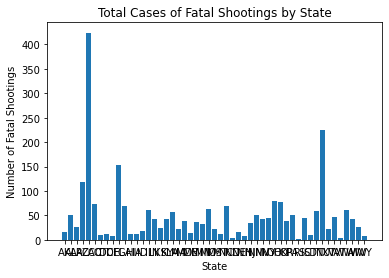

In [28]:
'''
The goal is to make a visualization of our data so we can find out which state in the set has the most fatal police shootings

Create a bar graph using the df_state_stats DataFrame to visualize the trend of fatal shootings per state
'''

plt.bar(df_state_stats.index, df_state_stats['Total Cases'])
plt.title('Total Cases of Fatal Shootings by State')
plt.xlabel('State')
plt.ylabel('Number of Fatal Shootings')
plt.show()

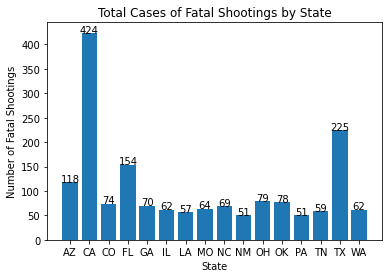

In [29]:
'''
The above bar graph is extremely packed and the majority of the values are very small, so they don't matter to us when trying to determine which states have the highest number of fatal shootings. Let's repeat the process using only the states with number of killings greater than 50. With this, we can see the data better.
'''

df_state_stats_temp = df_state_stats[df_state_stats['Total Cases'] > 50]
# df_state_stats_temp

# plt.bar(df_state_stats_temp.index, df_state_stats_temp['Total Cases'])
# plt.title('Total Cases of Fatal Shootings by State')
# plt.xlabel('State')
# plt.ylabel('Number of Fatal Shootings')
# plt.show()

x_list = list(df_state_stats_temp.index)
y_list = list(df_state_stats_temp['Total Cases'])
plt.bar(x_list, y_list)
plt.title('Total Cases of Fatal Shootings by State')
plt.xlabel('State')
plt.ylabel('Number of Fatal Shootings')
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

In [30]:
'''
The graph clearly shows that CA is the state with the highest number of fatal police shootings (over 400), followed by TX with slightly over 200 fatal shootings.

We can confirm this conclusion using code by extracting the maximum value of 'Total Cases' from the DataFrame and seeing which state it is associated with. 
The line of code below accomplishes this and does indeed confirm that CA is the state with the highest number of fatal shootings (424). 
'''
s = df_state_stats.loc[df_state_stats['Total Cases'].idxmax()]
s.name, s['Total Cases']

('CA', 424)

In [31]:
df_state_stats.columns

Index(['Total Cases', 'MANNER_OF_DEATH: shot',
       'MANNER_OF_DEATH: shot and Tasered', 'GENDER: M', 'GENDER: F',
       'RACE: A', 'RACE: W', 'RACE: H', 'RACE: B', 'RACE: O', 'RACE: N',
       'SIGNS_OF_MENTAL_ILLNESS: True', 'SIGNS_OF_MENTAL_ILLNESS: False',
       'THREAT_LEVEL: attack', 'THREAT_LEVEL: other',
       'THREAT_LEVEL: undetermined', 'FLEE: Not fleeing', 'FLEE: Car',
       'FLEE: Foot', 'FLEE: Other', 'BODY_CAMERA: False', 'BODY_CAMERA: True',
       'ARMED: gun', 'ARMED: unarmed', 'ARMED: toy weapon', 'ARMED: nail gun',
       'ARMED: knife', 'ARMED: vehicle', 'ARMED: shovel', 'ARMED: hammer',
       'ARMED: hatchet', 'ARMED: undetermined', 'ARMED: sword',
       'ARMED: machete', 'ARMED: box cutter', 'ARMED: metal object',
       'ARMED: screwdriver', 'ARMED: lawn mower blade', 'ARMED: flagpole',
       'ARMED: guns and explosives', 'ARMED: cordless drill',
       'ARMED: crossbow', 'ARMED: metal pole', 'ARMED: Taser',
       'ARMED: metal pipe', 'ARMED: metal han

In [32]:
'''
The goal is to find out what the most common way of being armed is. We can do this by iterating through every index and sum up the values in each column for method of arms

We can store the results in a dictionary
'''

armed_counts = dict()
armed_cols = [c for c in df_state_stats.columns if c[0:5] == "ARMED"]

for index, row in df_state_stats.iterrows():
    for col in armed_cols:
        arm_type = col[7:]
        armed_counts[arm_type] = armed_counts.get(arm_type, 0) + row[col]

'''
Now the armed_counts dictionary contains each way of being armed along with its corresponding number of appearances.

We can sort the dictionary by value in non-increasing order to determine what the most common ways of being armed are.

By doing this, we can see that the most common way of being armed is with a gun (1407 occurrences), followed by knife with 373 occurrences.
'''

armed_counts_list = sorted(armed_counts.items(), key=lambda x:x[1], reverse=True)
armed_counts_list

[('gun', 1407),
 ('knife', 373),
 ('vehicle', 177),
 ('unarmed', 171),
 ('undetermined', 117),
 ('toy weapon', 104),
 ('machete', 18),
 ('unknown weapon', 18),
 ('Taser', 9),
 ('ax', 9),
 ('sword', 8),
 ('baseball bat', 8),
 ('hammer', 7),
 ('box cutter', 7),
 ('metal pipe', 7),
 ('hatchet', 6),
 ('crossbow', 6),
 ('screwdriver', 5),
 ('blunt object', 5),
 ('gun and knife', 5),
 ('guns and explosives', 3),
 ('metal stick', 3),
 ('scissors', 3),
 ('rock', 3),
 ('shovel', 2),
 ('metal object', 2),
 ('metal pole', 2),
 ('sharp object', 2),
 ('meat cleaver', 2),
 ('beer bottle', 2),
 ('brick', 2),
 ('chain saw', 2),
 ('baton', 2),
 ('hatchet and gun', 2),
 ('piece of wood', 2),
 ('pipe', 2),
 ('nail gun', 1),
 ('lawn mower blade', 1),
 ('flagpole', 1),
 ('cordless drill', 1),
 ('metal hand tool', 1),
 ('carjack', 1),
 ('chain', 1),
 ("contractor's level", 1),
 ('stapler', 1),
 ('bean-bag gun', 1),
 ('baseball bat and fireplace poker', 1),
 ('straight edge razor', 1),
 ('hand torch', 1),
 (

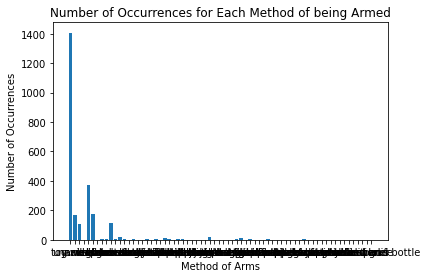

In [33]:
'''
We can also use a bar graph to visualize this data.
'''
plt.bar(armed_counts.keys(), armed_counts.values())
plt.title("Number of Occurrences for Each Method of being Armed")
plt.xlabel("Method of Arms")
plt.ylabel("Number of Occurrences")
plt.show()

In [34]:
armed_counts_reduced = dict()

for tup in armed_counts_list:
    if (tup[1] > 10):
        armed_counts_reduced[tup[0]] = tup[1]

armed_counts_reduced

{'gun': 1407,
 'knife': 373,
 'vehicle': 177,
 'unarmed': 171,
 'undetermined': 117,
 'toy weapon': 104,
 'machete': 18,
 'unknown weapon': 18}

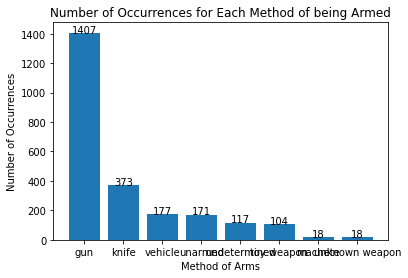

In [35]:
'''
We can also use a bar graph to visualize this data.
'''
# plt.bar(armed_counts_reduced.keys(), armed_counts_reduced.values())
# plt.title("Number of Occurrences for Each Method of being Armed")
# plt.xlabel("Method of Arms")
# plt.ylabel("Number of Occurrences")
# plt.show()


x_list = list(armed_counts_reduced.keys())
y_list = list(armed_counts_reduced.values())
plt.bar(x_list, y_list)
plt.title("Number of Occurrences for Each Method of being Armed")
plt.xlabel("Method of Arms")
plt.ylabel("Number of Occurrences")
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

In [36]:
'''
The graph above clearly shows that guns are the most common by a very wide margin, followed by knives in second and then vehicles in third place.
Interestingly, we can also see here that the 4th most common occurrence is actually "unarmed" - no weapons/items 
'''

'\nThe graph above clearly shows that guns are the most common by a very wide margin, followed by knives in second and then vehicles in third place.\nInterestingly, we can also see here that the 4th most common occurrence is actually "unarmed" - no weapons/items \n'

Text(0.5, 1.0, 'Age Distribution of All Victims')

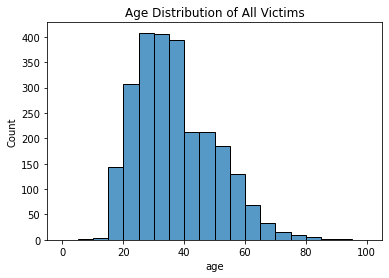

In [37]:
'''
Now let's look at the age distribution of all the victims
'''

all_hist = sb.histplot(df_total['age'], bins=20, binrange=(0,100))
all_hist.set_title("Age Distribution of All Victims")

Text(0.5, 1.0, 'Age Distribution of Asian Victims')

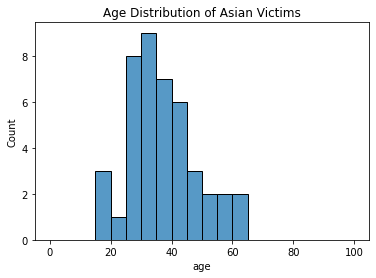

In [38]:
df_a = df_total[df_total['race'] == 'A']
a_hist = sb.histplot(df_a['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Asian Victims")

Text(0.5, 1.0, 'Age Distribution of White Victims')

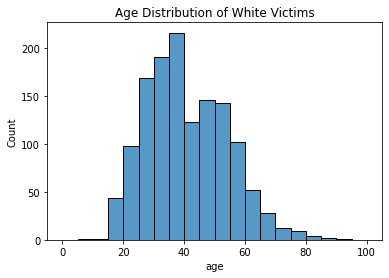

In [39]:
df_w = df_total[df_total['race'] == 'W']
w_hist = sb.histplot(df_w['age'], bins=20, binrange=(0,100))
w_hist.set_title("Age Distribution of White Victims")

Text(0.5, 1.0, 'Age Distribution of Black Victims')

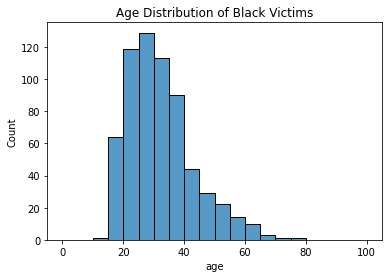

In [40]:
df_b = df_total[df_total['race'] == 'B']
b_hist = sb.histplot(df_b['age'], bins=20, binrange=(0,100))
b_hist.set_title("Age Distribution of Black Victims")

Text(0.5, 1.0, 'Age Distribution of Hispanic Victims')

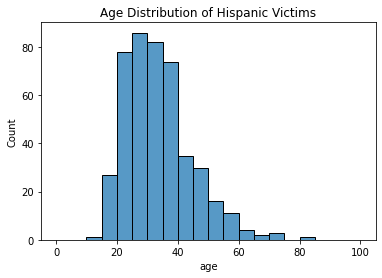

In [41]:
df_h = df_total[df_total['race'] == 'H']
a_hist = sb.histplot(df_h['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Hispanic Victims")

Text(0.5, 1.0, 'Age Distribution of Native American Victims')

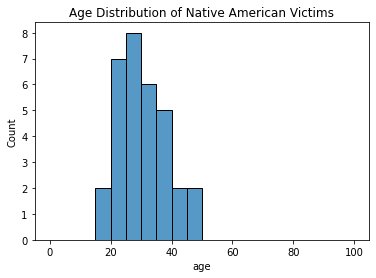

In [42]:
df_n = df_total[df_total['race'] == 'N']
a_hist = sb.histplot(df_n['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Native American Victims")

Text(0.5, 1.0, 'Age Distribution of Other Race Victims')

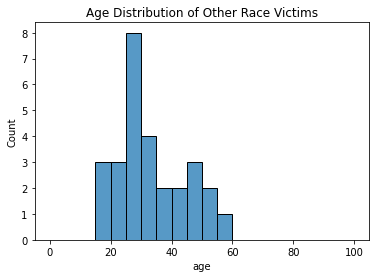

In [43]:
df_o = df_total[df_total['race'] == 'O']
a_hist = sb.histplot(df_o['age'], bins=20, binrange=(0,100))
a_hist.set_title("Age Distribution of Other Race Victims")

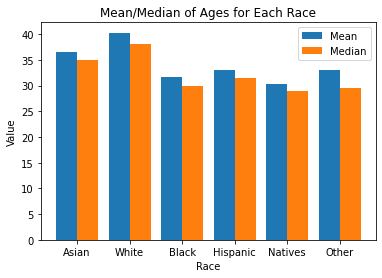

In [44]:
'''
Now let's graph the means and medians of the ages for each race and compare them
'''


races = ["Asian", "White", "Black", "Hispanic", "Natives", "Other"]
# mean_list, median_list = [], []
mean_list = [df_a['age'].mean()] + [df_w['age'].mean()] + [df_b['age'].mean()] + [df_h['age'].mean()] + [df_n['age'].mean()] + [df_o['age'].mean()]
median_list = [df_a['age'].median()] + [df_w['age'].median()] + [df_b['age'].median()] + [df_h['age'].median()] + [df_n['age'].median()] + [df_o['age'].median()]

x_axis = np.arange(len(races))

plt.bar(x_axis - 0.2, mean_list, width = 0.4, label = 'Mean')
plt.bar(x_axis + 0.2, median_list, width = 0.4, label = 'Median')

plt.title("Mean/Median of Ages for Each Race")
plt.xlabel("Race")
plt.ylabel("Value")

plt.xticks(x_axis, races)

plt.legend()

plt.show()

In [45]:
list(set(sorted(df_total['age'].unique())))
df_total['race'].unique()

array(['A', 'W', 'H', 'B', 'O', 'N'], dtype=object)

In [46]:
'''
Let's get the total number of people killed per race.
'''

race_count = df_total.groupby('race')['race'].size()
race_count 

race
A      43
B     640
H     450
N      32
O      28
W    1342
Name: race, dtype: int64

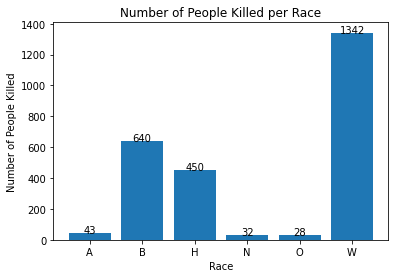

In [47]:
x_list = race_count.index.tolist()
y_list = race_count.tolist()
plt.bar(x_list, y_list)
plt.title("Number of People Killed per Race")
plt.xlabel("Race")
plt.ylabel("Number of People Killed")
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

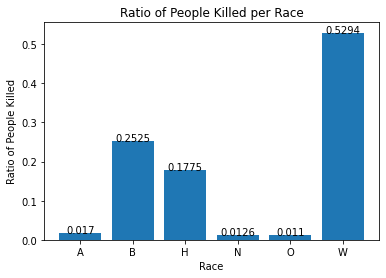

In [48]:
'''
Now we can find the ratio of deaths for each race over the total amount of deaths and visualize that data as well
'''

total_deaths = race_count.sum()
x_list = race_count.index.tolist()
y_list = [round((y / total_deaths), 4) for y in race_count.tolist()]
plt.bar(x_list, y_list)
plt.title("Ratio of People Killed per Race")
plt.xlabel("Race")
plt.ylabel("Ratio of People Killed")
for i in range(len(x_list)):
    plt.text(x_list[i], y_list[i], y_list[i], ha='center')
plt.show()

In [49]:
import warnings
warnings.filterwarnings("ignore")

cities.sort()
columns_race.sort()
races = df_total['race'].tolist()
races =list(set(races))
races.remove('O')
races.sort()
df_total['Median Income'] = np.nan
df_total['poverty_rate'] = np.nan
df_total['percent_completed_hs'] = np.nan
df_total_temp = df_total.copy()
for i in cities:
    temp = df_total_temp.loc[df_total_temp['city'] == i]
    supptemp = df_support.loc[df_support['city'] == i]
    support_proportion_race = {}
    ind = 0
    for j in columns_race:
        temp2 = temp.loc[temp['race'] == races[ind]]
        support_proportion_race['Median Income'] = supptemp['Median Income'].iat[0] * supptemp[j].iat[0]/100
        support_proportion_race['poverty_rate'] = supptemp['poverty_rate'].iat[0] * supptemp[j].iat[0]/100
        support_proportion_race['percent_completed_hs'] = supptemp['percent_completed_hs'].iat[0] * supptemp[j].iat[0]/100
        #tempDF = pd.DataFrame(support_proportion_race)
        # tempDF = pd.concat([tempDF]*len(temp2), ignore_index=True)
        #print(tempDF.info())
        # print(temp2.info())
        temp2['Median Income'] = temp2['Median Income'].fillna(support_proportion_race['Median Income'])
        temp2['poverty_rate']= temp2['poverty_rate'].fillna(support_proportion_race['poverty_rate'])
        temp2['percent_completed_hs'] = temp2['percent_completed_hs'].fillna(support_proportion_race['percent_completed_hs'])
        #print(temp2.info())
        temp.loc[temp['race'] == races[ind]] = temp2
        #print(temp.info())
        ind+=1
        #print(temp.info())
    temp = temp.fillna(0)
    df_total_temp.loc[df_total_temp['city'] == i] = temp

df_total = df_total_temp
df_total

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,Median Income,poverty_rate,percent_completed_hs
0,3.0,Tim Elliot,02/01/15,shot,gun,53.000000,M,A,WA-Shelton,WA,True,attack,Not fleeing,False,407.79200,0.314600,0.881100
1,4.0,Lewis Lee Lembke,02/01/15,shot,gun,47.000000,M,W,OR-Aloha,OR,False,attack,Not fleeing,False,46627.38500,10.564100,62.462900
2,5.0,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.000000,M,H,KS-Wichita,KS,False,other,Not fleeing,False,7029.89100,2.646900,13.387500
3,8.0,Matthew Hoffman,04/01/15,shot,toy weapon,32.000000,M,W,CA-San Francisco,CA,True,attack,Not fleeing,False,39427.59000,6.402000,42.195000
4,9.0,Michael Rodriguez,04/01/15,shot,nail gun,39.000000,M,H,CO-Evans,CO,False,attack,Not fleeing,False,20597.92100,7.154600,32.885300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822.0,Rodney E. Jacobs,28/07/17,shot,gun,31.000000,M,B,MO-Kansas City,MO,False,attack,Not fleeing,False,13700.47900,5.681000,26.431600
2531,2813.0,TK TK,28/07/17,shot,vehicle,31.153846,M,H,NM-Albuquerque,NM,False,attack,Car,False,21963.01000,8.966400,41.563000
2532,2818.0,Dennis W. Robinson,29/07/17,shot,gun,48.000000,M,W,ID-Melba,ID,False,attack,Car,False,32470.50600,12.939600,71.325600
2533,2817.0,Isaiah Tucker,31/07/17,shot,vehicle,28.000000,M,B,WI-Oshkosh,WI,False,attack,Car,True,1322.15000,0.554900,2.768300


In [50]:
df_total_copy = df_total.copy()

# pd.get_dummies(df_total_copy, columns=['manner_of_death', 'armed', 'gender', 'city', ])
df_temp = df_total_copy.drop(columns=['id', 'name', 'date', 'state'])
# df_temp

df_temp = pd.get_dummies(df_temp, columns=['manner_of_death', 'armed', 'gender', 'city', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera'])

training_es_x = df_temp.iloc[0:2028].drop(columns=['race'])
training_es_y = df_temp.iloc[0:2028]['race']

testing_es_x = df_temp.iloc[2028:].drop(columns=['race'])
testing_es_y = df_temp.iloc[2028:]['race']

testing_es_x

,age,Median Income,poverty_rate,percent_completed_hs,manner_of_death_shot,manner_of_death_shot and Tasered,armed_Taser,armed_air conditioner,armed_ax,armed_baseball bat,...,signs_of_mental_illness_True,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,body_camera_False,body_camera_True
2028,54.000000,12926.39400,2.530800,19.624800,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2029,50.000000,48514.56000,14.112000,78.720000,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
2030,28.000000,7026.44700,2.200800,11.580400,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2031,59.000000,45897.17400,5.453100,67.902300,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
2032,24.000000,25664.58000,13.284000,48.060000,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,31.000000,13700.47900,5.681000,26.431600,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2531,31.153846,21963.01000,8.966400,41.563000,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2532,48.000000,32470.50600,12.939600,71.325600,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2533,28.000000,1322.15000,0.554900,2.768300,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [51]:
df_temp['race'].unique()

array(['A', 'W', 'H', 'B', 'O', 'N'], dtype=object)

In [52]:
model = LogisticRegression(max_iter=3000)

model.fit(training_es_x, training_es_y)
predict_train = model.predict(training_es_x)

predict_test = model.predict(testing_es_x)
predict_test

array(['W', 'W', 'B', 'W', 'W', 'B', 'B', 'W', 'W', 'W', 'B', 'W', 'H',
       'B', 'W', 'W', 'W', 'W', 'B', 'B', 'B', 'B', 'W', 'B', 'B', 'W',
       'B', 'W', 'B', 'W', 'B', 'W', 'W', 'W', 'W', 'B', 'B', 'W', 'W',
       'B', 'W', 'B', 'B', 'W', 'W', 'W', 'B', 'B', 'W', 'B', 'B', 'W',
       'B', 'B', 'B', 'W', 'W', 'W', 'H', 'W', 'W', 'B', 'W', 'B', 'W',
       'W', 'W', 'W', 'B', 'W', 'W', 'W', 'B', 'W', 'W', 'B', 'W', 'B',
       'W', 'B', 'W', 'B', 'W', 'B', 'W', 'B', 'B', 'W', 'B', 'W', 'W',
       'W', 'W', 'W', 'B', 'W', 'B', 'W', 'W', 'B', 'W', 'B', 'B', 'W',
       'W', 'W', 'W', 'B', 'B', 'W', 'W', 'B', 'W', 'W', 'B', 'B', 'B',
       'W', 'W', 'W', 'W', 'W', 'B', 'W', 'W', 'B', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'W', 'B', 'W',
       'W', 'B', 'W', 'B', 'W', 'W', 'H', 'B', 'W', 'B', 'B', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'B', 'W', 'W', 'W', 'W',
       'B', 'B', 'B', 'B', 'B', 'W', 'H', 'B', 'W', 'W', 'W', 'W

In [53]:
set(predict_test)

{'B', 'H', 'W'}

In [54]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_test = accuracy_score(testing_es_y, predict_test)
# accuracy_test = accuracy_score(training_es_y, predict_train)
accuracy_test

# f1_score(testing_es_y, predict_test, average=None)

0.6094674556213018

In [57]:
tmodel = DecisionTreeClassifier()
# tmodel.fit(training_es_x, training_es_y)
# predict_train_tree = tmodel
tmodel.fit(training_es_x, training_es_y)
predict_tree = tmodel.predict(training_es_x)

predict_test_tree = tmodel.predict(testing_es_x)
accuracy_test_tree = accuracy_score(testing_es_y, predict_test_tree)
accuracy_test_tree

0.8126232741617357

[Text(0.5947870218528891, 0.9827586206896551, 'X[3] <= 51.538\ngini = 0.626\nsamples = 2028\nvalue = [34, 513, 355, 28, 28, 1070]'),
 Text(0.22907876068691038, 0.9482758620689655, 'X[2] <= 0.022\ngini = 0.702\nsamples = 1289\nvalue = [34, 481, 340, 25, 28, 381]'),
 Text(0.07311320754716981, 0.9137931034482759, 'X[1] <= 1.249\ngini = 0.425\nsamples = 163\nvalue = [5, 120, 7, 3, 28, 0]'),
 Text(0.06367924528301887, 0.8793103448275862, 'X[1239] <= 0.5\ngini = 0.067\nsamples = 29\nvalue = [0, 1, 0, 0, 28, 0]'),
 Text(0.0589622641509434, 0.8448275862068966, 'gini = 0.0\nsamples = 28\nvalue = [0, 0, 0, 0, 28, 0]'),
 Text(0.06839622641509434, 0.8448275862068966, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0, 0]'),
 Text(0.08254716981132075, 0.8793103448275862, 'X[1023] <= 0.5\ngini = 0.207\nsamples = 134\nvalue = [5, 119, 7, 3, 0, 0]'),
 Text(0.07783018867924528, 0.8448275862068966, 'X[344] <= 0.5\ngini = 0.183\nsamples = 132\nvalue = [3, 119, 7, 3, 0, 0]'),
 Text(0.06839622641509434, 0.81

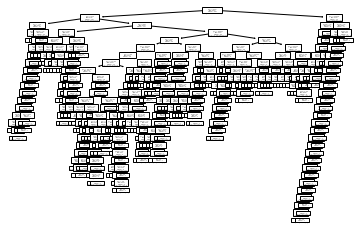

In [63]:
sklearn.tree.plot_tree(tmodel)

In [58]:
from sklearn.naive_bayes import GaussianNB

bmodel = GaussianNB()

bmodel.fit(training_es_x, training_es_y)

predict_train_b = bmodel.predict(training_es_x)
accuracy_train_b = accuracy_score(training_es_y, predict_train_b)
accuracy_train_b

0.6232741617357002

In [59]:
predict_test_b = bmodel.predict(testing_es_x)
predict_test_b 

array(['B', 'W', 'B', 'W', 'H', 'B', 'B', 'W', 'W', 'W', 'B', 'A', 'W',
       'A', 'W', 'W', 'W', 'A', 'B', 'B', 'B', 'B', 'W', 'B', 'B', 'W',
       'W', 'W', 'B', 'W', 'B', 'W', 'A', 'B', 'A', 'A', 'B', 'A', 'A',
       'B', 'B', 'B', 'B', 'W', 'W', 'H', 'B', 'B', 'A', 'B', 'B', 'W',
       'B', 'B', 'B', 'A', 'W', 'B', 'B', 'W', 'W', 'B', 'B', 'B', 'H',
       'H', 'W', 'W', 'B', 'A', 'W', 'W', 'B', 'W', 'W', 'B', 'W', 'B',
       'W', 'B', 'W', 'B', 'B', 'A', 'B', 'B', 'B', 'W', 'B', 'W', 'W',
       'W', 'W', 'B', 'B', 'B', 'A', 'W', 'A', 'B', 'W', 'B', 'B', 'W',
       'W', 'W', 'W', 'B', 'B', 'W', 'W', 'A', 'W', 'W', 'B', 'B', 'B',
       'W', 'B', 'W', 'H', 'H', 'B', 'W', 'W', 'B', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'H', 'W', 'W', 'W', 'B', 'A', 'B', 'H',
       'W', 'B', 'W', 'B', 'W', 'W', 'H', 'B', 'W', 'B', 'B', 'B', 'W',
       'B', 'W', 'W', 'A', 'W', 'W', 'H', 'W', 'B', 'W', 'B', 'W', 'W',
       'B', 'B', 'A', 'B', 'H', 'A', 'W', 'B', 'H', 'W', 'W', 'W

In [60]:
accuracy_test_b = accuracy_score(testing_es_y, predict_test_b)
accuracy_test_b 

0.5976331360946746

In [61]:
from sklearn.neighbors import KNeighborsClassifier

model_k = KNeighborsClassifier()

model_k.fit(training_es_x, training_es_y)
predict_train_k = model_k.predict(training_es_x)

accuracy_train_k = accuracy_score(training_es_y, predict_train_k)
accuracy_train_k
# f1_score(training_es_y, predict_train_k, average=None)

0.8436883629191322

In [62]:
predict_test_k = model_k.predict(testing_es_x)
accuracy_test_k = accuracy_score(testing_es_y, predict_test_k)
accuracy_test_k

0.7692307692307693